#  NLP CHATBOT AND TEXT SUMMARIZATION MODEL TRAINING AND EVALUATION

# 0.Installing Dependencies

In [1]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q
!pip install transformers[torch]
!pip install accelerate>=0.21.0 transformers>=4.11.0
!pip install accelerate -U
!nvidia-smi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.2/411.2 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 

# **1**. Loading Neccecery Libraries

In [2]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
from datasets import load_dataset, load_metric
from torch.utils.data import DataLoader
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# **2.Loading model and tokenizer**

In [3]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "google/pegasus-cnn_dailymail"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

# **3.Preprocessing function**

In [4]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]


In [5]:
def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                                 column_text="article", column_summary="highlights",
                                 batch_size=16, device=device):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, truncation=True, max_length=250,  # Truncation here
                           padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                                   attention_mask=inputs["attention_mask"].to(device),
                                   length_penalty=0.8, num_beams=8, min_length=1, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''

        # Finally, we decode the generated texts,
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]


        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

# **4. Loading chatdata_foodBuddy dataset**


In [6]:
dataset_foodbuddy = load_dataset("VishwasBhushanB/chatdata_foodBuddy")

split_lengths = [len(dataset_foodbuddy[split]) for split in dataset_foodbuddy]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_foodbuddy['train'].column_names}")
print("\nDialogue:")

print(dataset_foodbuddy["train"][1]["dialogue"])

print("\nSummary:")

print(dataset_foodbuddy["train"][1]["summary"])


Generating train split:   0%|          | 0/291 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/296 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/26 [00:00<?, ? examples/s]

Split lengths: [291, 296, 26]
Features: ['summary', 'dialogue', 'id']

Dialogue:
Customer: Chole Bhature is my favorite comfort food, and this one didn't disappoint!
Bot Response: We're thrilled you loved our Chole Bhature! Your positive feedback motivates us.

Summary:
Customer's favorite comfort food, Chole Bhature, didn't disappoint.


# **5.Caluculating rouge score**

In [43]:
from transformers import pipeline
from datasets import load_metric
import pandas as pd

pipe = pipeline('summarization', model=model_ckpt)

# Example input text
sample_text = "Customer: one masala dosa Bot Response: So far you have: 1 Masala Dosa. Do you need anything else? Customer: 1 pizza Bot Response: So far you have: 1 Masala Dosa, 1 Pizza. Do you need anything else? Customer: one rava dosa Bot Response: So far you have: 1 Masala Dosa, 1 Pizza, 1 Rava Dosa. Do you need anything else? Customer: Thats it Bot Response: Awesome. We have placed your order. Here is your order id # 64. Your order total is 21.00 which you can pay at the time of delivery! Customer: my order id is 64 Bot Response: The order status for order id: 64 is: in progress Customer: The delivery took much longer than promised. Very disappointed with the service Bot Response: We apologize for any inconvenience caused by the delivery. Your feedback is valuable to us. Please contact us so we can address this issue promptly. Customer: The Rava Dosa was burnt and had a bitter aftertaste Bot Response: We're sorry to hear that review The Rava Dosa was burnt and had a bitter aftertaste from you. Your feedback is important to us. Please contact us so we can address this issue promptly. Customer: masala dosa was bad Bot Response: We're sorry to hear that review masala dosa was bad from you. Your feedback is important to us. Please contact us so we can address this issue promptly. Customer: Masala Dosa for $6 feels high  price. Bot Response: We're sorry to hear that review regarding Masala Dosa priced at $6.00 from you. Your feedback is important to us. Please contact us so we can address this issue promptly."


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
# Specify your reference summary
reference_summary = "This dialogue represents a customer placing an order at a restaurant and providing feedback on their experience. The customer initially orders a Masala Dosa, a Pizza, and a Rava Dosa. After receiving the order (Order ID #64), the customer experiences a delay in delivery and expresses disappointment with the service. They also report that the Rava Dosa was burnt with a bitter aftertaste and that the Masala Dosa was not satisfactory. Additionally, the customer feels that the price of $6 for the Masala Dosa is too high. In each instance of feedback, the restaurant responds by acknowledging the issue and encouraging the customer to contact them to address the concerns."

# Generate summary
pipe_out = pipe(sample_text)
output_summary = pipe_out[0]['summary_text'].replace(" .", ".\n")

# Print the generated summary
print("Generated Summary:")
print(output_summary)


Generated Summary:
So far you have: 1 Masala Dosa, 1 Pizza, 1 Rava Dosa.
<n>The delivery took much longer than promised.
<n>The Rava Dosa was burnt and had a bitter aftertaste.



In [48]:
# Load ROUGE metric
rouge = load_metric('rouge')

# Calculate ROUGE scores
results = rouge.compute(predictions=[output_summary], references=[reference_summary])

# Print ROUGE scores
print("ROUGE Scores:")
for key, value in results.items():
    print(f"{key}: {value.mid.fmeasure:.3f}")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


ROUGE Scores:
rouge1: 0.227
rouge2: 0.115
rougeL: 0.213
rougeLsum: 0.199


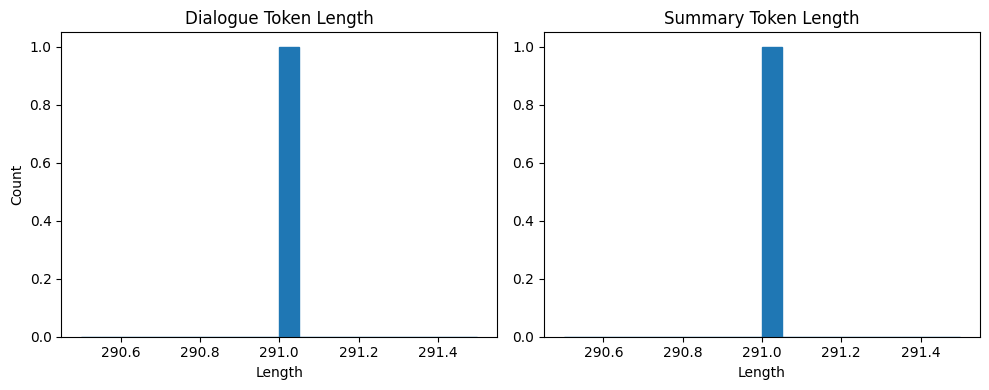

In [9]:
dialogue_token_len = len([tokenizer.encode(s) for s in dataset_foodbuddy['train']['dialogue']])

summary_token_len = len([tokenizer.encode(s) for s in dataset_foodbuddy['train']['summary']])


fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(dialogue_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [10]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'] , max_length = 9, truncation = True )

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 9, truncation = True )

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

dataset_samsum_pt = dataset_foodbuddy.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/291 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3921: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/296 [00:00<?, ? examples/s]

Map:   0%|          | 0/26 [00:00<?, ? examples/s]

# **7.Mount Google drive**

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
%cd /content/drive/MyDrive/Opencv/summarizedModel


/content/drive/MyDrive/Opencv/summarizedModel


# **8.Start Training**

In [13]:
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

trainer_args = TrainingArguments(
    output_dir='pegasus-chatbot', num_train_epochs=100, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
)

In [14]:
trainer = Trainer(model=model_pegasus, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["train"])

In [15]:
trainer.train()

Step,Training Loss,Validation Loss
500,1.035200,0.634019
1000,0.118900,0.027949
1500,0.071100,0.019183


Step,Training Loss,Validation Loss
500,1.035200,0.634019
1000,0.118900,0.027949
1500,0.071100,0.019183


TrainOutput(global_step=1800, training_loss=0.838705884963274, metrics={'train_runtime': 3678.8426, 'train_samples_per_second': 7.91, 'train_steps_per_second': 0.489, 'total_flos': 731395679846400.0, 'train_loss': 0.838705884963274, 'epoch': 98.96907216494846})

In [17]:
## Save model
model_pegasus.save_pretrained("pegasus-foodbuddy-model")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}


In [18]:
## Save tokenizer
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/spiece.model',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [19]:
dataset_foodbuddy = load_dataset("VishwasBhushanB/chatdata_foodBuddy")

In [20]:
tokenizer = AutoTokenizer.from_pretrained("tokenizer")

In [23]:
sample_text = "Customer: one masala dosa Bot Response: So far you have: 1 Masala Dosa. Do you need anything else? Customer: 1 pizza Bot Response: So far you have: 1 Masala Dosa, 1 Pizza. Do you need anything else? Customer: one rava dosa Bot Response: So far you have: 1 Masala Dosa, 1 Pizza, 1 Rava Dosa. Do you need anything else? Customer: Thats it Bot Response: Awesome. We have placed your order. Here is your order id # 64. Your order total is 21.00 which you can pay at the time of delivery! Customer: my order id is 64 Bot Response: The order status for order id: 64 is: in progress Customer: The delivery took much longer than promised. Very disappointed with the service Bot Response: We apologize for any inconvenience caused by the delivery. Your feedback is valuable to us. Please contact us so we can address this issue promptly. Customer: The Rava Dosa was burnt and had a bitter aftertaste Bot Response: We're sorry to hear that review The Rava Dosa was burnt and had a bitter aftertaste from you. Your feedback is important to us. Please contact us so we can address this issue promptly. Customer: masala dosa was bad Bot Response: We're sorry to hear that review masala dosa was bad from you. Your feedback is important to us. Please contact us so we can address this issue promptly. Customer: Masala Dosa for $6 feels high  price. Bot Response: We're sorry to hear that review regarding Masala Dosa priced at $6.00 from you. Your feedback is important to us. Please contact us so we can address this issue promptly."

In [30]:
gen_kwargs = {"length_penalty": 10, "num_beams":50, "max_length": 128}

pipe = pipeline("summarization", model="pegasus-foodbuddy-model",tokenizer=tokenizer)

In [31]:
print("Dialogue:")
print(sample_text)



print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Dialogue:
Customer: one masala dosa Bot Response: So far you have: 1 Masala Dosa. Do you need anything else? Customer: 1 pizza Bot Response: So far you have: 1 Masala Dosa, 1 Pizza. Do you need anything else? Customer: one rava dosa Bot Response: So far you have: 1 Masala Dosa, 1 Pizza, 1 Rava Dosa. Do you need anything else? Customer: Thats it Bot Response: Awesome. We have placed your order. Here is your order id # 64. Your order total is 21.00 which you can pay at the time of delivery! Customer: my order id is 64 Bot Response: The order status for order id: 64 is: in progress Customer: The delivery took much longer than promised. Very disappointed with the service Bot Response: We apologize for any inconvenience caused by the delivery. Your feedback is valuable to us. Please contact us so we can address this issue promptly. Customer: The Rava Dosa was burnt and had a bitter aftertaste Bot Response: We're sorry to hear that review The Rava Dosa was burnt and had a bitter aftertaste f

In [49]:
# Load ROUGE metric
rouge = load_metric('rouge')

# Calculate ROUGE scores
results = rouge.compute(predictions=[pipe(sample_text, **gen_kwargs)[0]["summary_text"]], references=[reference_summary])

# Print ROUGE scores
print("ROUGE Scores:")
for key, value in results.items():
    print(f"{key}: {value.mid.fmeasure:.3f}")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


ROUGE Scores:
rouge1: 0.340
rouge2: 0.137
rougeL: 0.291
rougeLsum: 0.291


In [32]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


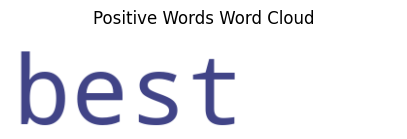

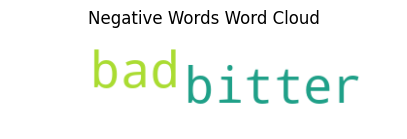

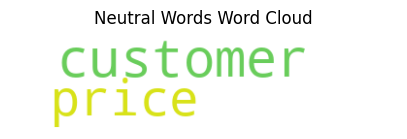

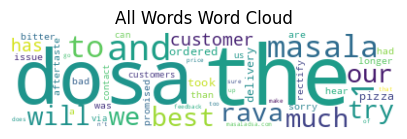

Normalized Sentiment Score: 3.00
Sentiment Category: Neutral


In [42]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob
import nltk

# Ensure necessary NLTK resources are downloaded
nltk.download('averaged_perceptron_tagger')

# Manually define some common positive and negative words for demonstration
positive_words_set = {'good', 'great', 'excellent', 'happy', 'love', 'best', 'beautiful'}
negative_words_set = {'bad', 'worse', 'worst', 'sad', 'angry', 'bitter'}
neutral_words_set = {'order', 'customer', 'service', 'price'}

def plot_wordcloud(word_dict, title):
    wordcloud = WordCloud(width=400, height=100, background_color='white').generate_from_frequencies(word_dict)
    plt.figure(figsize=(5, 2.5))  # Adjusted size for smaller display
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

def analyze_text_and_visualize(text):
    blob = TextBlob(text)

    positive_words = {}
    negative_words = {}
    neutral_words = {}
    all_words = {}

    # Classifying words and counting frequency
    for word in blob.words:
        word_lower = word.lower()
        if word_lower in positive_words_set:
            positive_words[word_lower] = positive_words.get(word_lower, 0) + 1
        elif word_lower in negative_words_set:
            negative_words[word_lower] = negative_words.get(word_lower, 0) + 1
        elif word_lower in neutral_words_set:
            neutral_words[word_lower] = neutral_words.get(word_lower, 0) + 1
        all_words[word_lower] = all_words.get(word_lower, 0) + 1

    # Plotting the word clouds
    plot_wordcloud(positive_words, 'Positive Words Word Cloud')
    plot_wordcloud(negative_words, 'Negative Words Word Cloud')
    plot_wordcloud(neutral_words, 'Neutral Words Word Cloud')
    plot_wordcloud(all_words, 'All Words Word Cloud')

    # Perform sentiment analysis
    sentiment_polarity = blob.sentiment.polarity

    # Normalize the sentiment score to a 0-5 range
    normalized_score = (sentiment_polarity + 1) * 2.5  # Maps -1 to 1 into 0 to 5

    # Determine sentiment category
    if normalized_score < 2:
        sentiment_category = "Negative"
    elif normalized_score > 3:
        sentiment_category = "Positive"
    else:
        sentiment_category = "Neutral"

    print(f"Normalized Sentiment Score: {score:.2f}")
    print(f"Sentiment Category: {category}")

# Example text
text = "Customer has ordered 1 Masala Dosa, 1 Pizza, and 1 Rava Dosa. The delivery took much longer than promised and the Rava Dosa had a bitter aftertaste. We are sorry to hear the Masala Dosa was bad and will try our best to rectify the issue. Customers can contact us via feedback@masaladsa.com and we will try our best to make sure that the price of the Masala Dosa doesn't go up too much."

# Analyze the text and visualize the word clouds
analyze_text_and_visualize(text)
